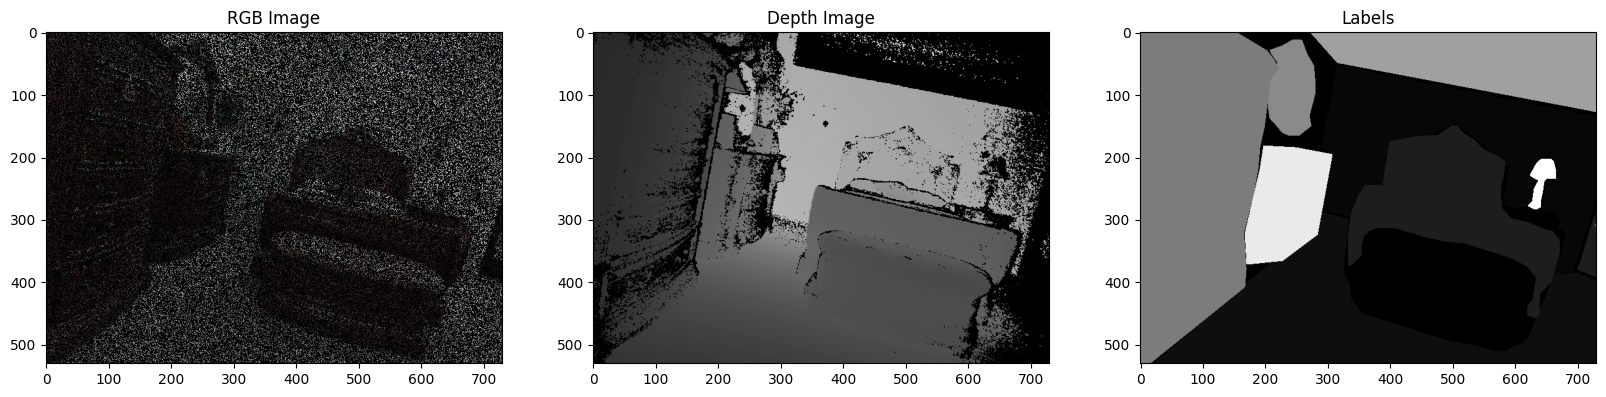

(530, 730) (530, 730, 3) (530, 730)
(530, 730, 3) (386900,) (1160700,) (2321400,) (2321400,)


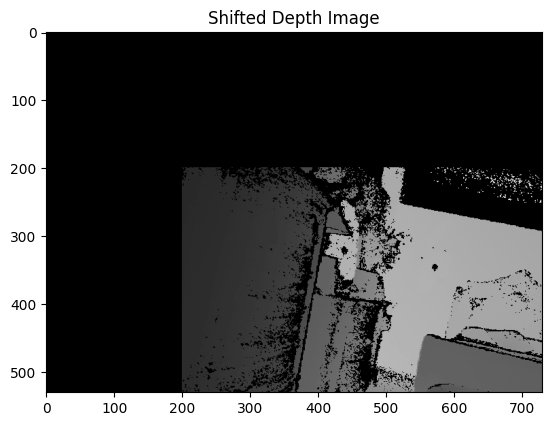

Mutual Information (RGB + Depth): 0.5181656237999032
Mutual Information (RGB): 0.13343606866781876
Mutual Information (Depth): 0.9376497963661263
Mutual Information (Shifted Depth): 0.5363584192287576
Mutual Information (GT): 1.9575195747001664
Mutual Information (Black): 0.0


In [1]:
import PIL.Image as Image
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

from sklearn.metrics import mutual_info_score
import numpy as np

rgb_sunrgbd_path = r"..\datasets\SUNRGBD\RGB"
depth_sunrgbd_path = r"..\datasets\SUNRGBD\Depth"
label_sunrgbd_path = r"..\datasets\SUNRGBD\labels"

example_rgb = rgb_sunrgbd_path + r"\test_0.jpg"
example_depth = depth_sunrgbd_path + r"\test_0.png"
example_label = label_sunrgbd_path + r"\test_0.png"


depth_image = np.array(Image.open(example_depth))
rgb_image = np.array(Image.open(example_rgb))
label = np.array(Image.open(example_label))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(rgb_image)
ax[0].set_title("RGB Image")
ax[1].imshow(depth_image, cmap="gray")
ax[1].set_title("Depth Image")
ax[2].imshow(label, cmap="gray")
ax[2].set_title("Labels")
plt.show()

print(depth_image.shape, rgb_image.shape, label.shape)
# Assuming you have labels, RGB images, and depth images as numpy arrays
# labels.shape = (height, width)
# rgb_images.shape = (height, width, 3)
# depth_images.shape = (height, width)

# Expand the labels to create the same shape as RGB
labels_rgb = np.expand_dims(label, axis=-1)
labels_rgb = np.repeat(labels_rgb, 3, axis=-1)

depth_3c = np.expand_dims(depth_image, axis=-1)
depth_3c = np.repeat(depth_3c, 3, axis=-1)
rgbd = np.concatenate([rgb_image, depth_3c], axis=-1)

labels_rgbd = np.expand_dims(label, axis=-1)
labels_rgbd = np.repeat(labels_rgbd, 6, axis=-1)
labels_rgbd_flat = labels_rgbd.flatten()

# Flatten the depth and RGB images to match the shape of labels
depth_flat = depth_image.flatten()
rgb_flat = rgb_image.flatten()
rgbd_flat = rgbd.flatten()
print(labels_rgb.shape, depth_flat.shape, rgb_flat.shape, rgbd_flat.shape, labels_rgbd_flat.shape)

# Shift depth image 50 pixels down and 50 pixels right
depth_shifted = np.zeros_like(depth_image)
shift = 200
depth_shifted[shift:, shift:] = depth_image[:-shift, :-shift]
depth_shifted_flat = depth_shifted.flatten()

# Calculate mutual information between RGB images and labels
mi_rgb = mutual_info_score(labels_rgb.flatten(), rgb_flat)

# Calculate mutual information between depth images and labels
mi_depth = mutual_info_score(label.flatten(), depth_flat)

mi_shifted_depth = mutual_info_score(label.flatten(), depth_shifted_flat)
plt.imshow(depth_shifted, cmap="gray")
plt.title("Shifted Depth Image")
plt.show()

# Calculate mutual information between RGB and depth images and labels
mi_rgb_depth = mutual_info_score(labels_rgbd_flat, rgbd_flat)

mi_gt = mutual_info_score(label.flatten(), label.flatten())
mi_black = mutual_info_score(label.flatten(), np.zeros_like(label.flatten()))

# Print the mutual information scores
print("Mutual Information (RGB + Depth):", mi_rgb_depth)
print("Mutual Information (RGB):", mi_rgb)
print("Mutual Information (Depth):", mi_depth)
print("Mutual Information (Shifted Depth):", mi_shifted_depth)
print("Mutual Information (GT):", mi_gt)
print("Mutual Information (Black):", mi_black)


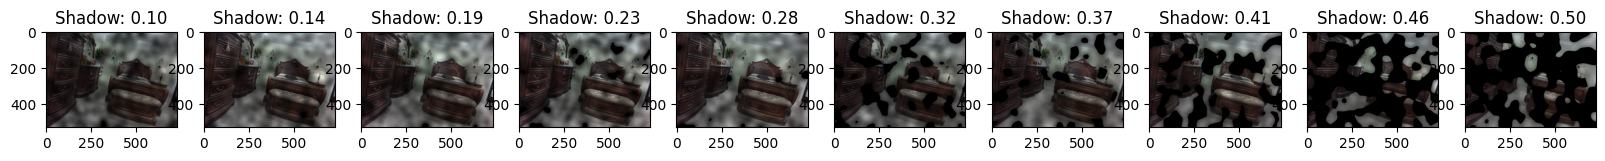

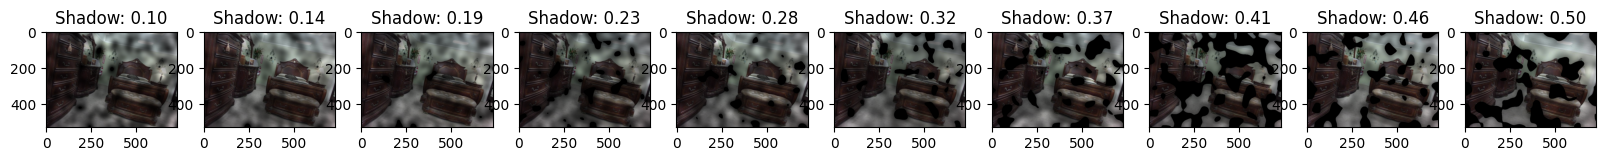

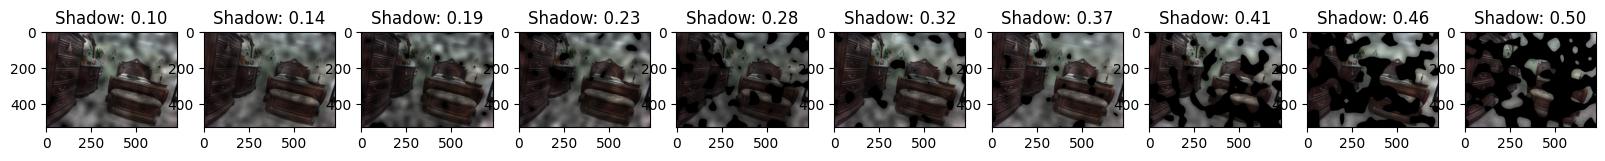

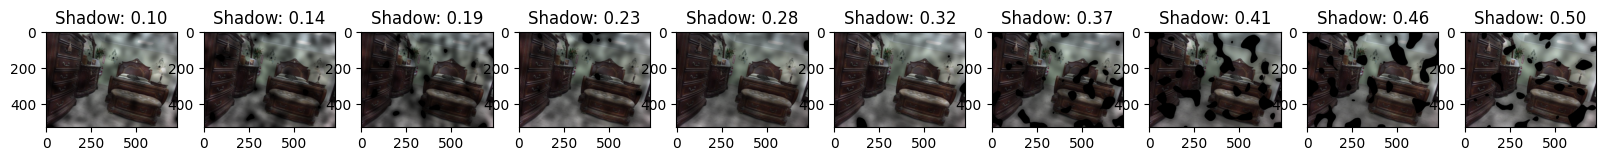

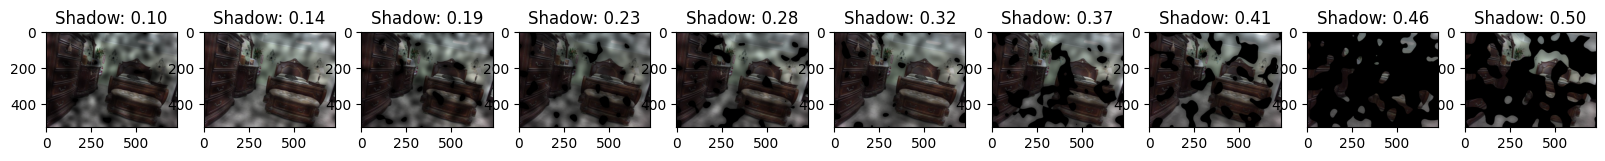

In [38]:
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter

rgb_sunrgbd_path = r"..\datasets\SUNRGBD\RGB_original"

example_rgb = rgb_sunrgbd_path + r"\test_0.jpg"

rgb_image = np.array(Image.open(example_rgb))

def adjust_shadow(image_path, shadow_percentage):
    # Open the image
    image = Image.open(image_path)
    image = np.array(image)

    # Calculate blob size based on shadow_percentage
    # Increase blob size towards shadow_percentage of 0.99
    blob_size = 15 + int(10 * shadow_percentage)

    # Create a binary mask with Gaussian blobs
    mask = np.random.rand(*image.shape[:2]) > shadow_percentage
    mask = gaussian_filter(mask.astype(float), sigma=blob_size)

    # Normalize the mask to ensure values are between 0 and 1
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    
    # Apply a nonlinear filter so that the mask < 0.5 is 0 and mask > 0.5 is mask
    mask = np.where(mask < shadow_percentage, 0, mask)

    # Create a 3D mask by stacking the 2D mask along the color dimension
    mask = np.stack([mask]*3, axis=-1)

    # Apply the mask to the image, reducing the pixel values where the mask is 1
    shadowed_image = image * mask

    # Convert the image back to its original data type
    shadowed_image = shadowed_image.astype(image.dtype)

    # Convert shadowed_image to PIL Image object
    shadowed_image = Image.fromarray(shadowed_image)

    return shadowed_image

for j in range(5):
    shadow_percentage = np.linspace(0.1, 0.5, 10)
    blob_size = 10
    fig, ax = plt.subplots(1, 10, figsize=(20, 10))
    for i, shadow in enumerate(shadow_percentage):
        shadowed_image = adjust_shadow(example_rgb, shadow)
        ax[i].imshow(shadowed_image)
        ax[i].set_title(f"Shadow: {shadow:.2f}")
    plt.show()

In [41]:
import numpy as np
from scipy.linalg import sqrtm
from skimage.util import view_as_windows

# def calculate_rmi(image_a, image_b, radius):
#     # Step 1: Create the co-occurrence vectors
#     window_shape = (2*radius + 1, 2*radius + 1, image_a.shape[-1])
#     windows_a = view_as_windows(image_a, window_shape)
#     windows_b = view_as_windows(image_b, window_shape)
#     vectors = np.stack((windows_a, windows_b), axis=-1)
#     vectors = vectors.reshape(-1, vectors.shape[-2]*vectors.shape[-1])

#     # Step 2: Center the points at the origin
#     mean_vector = np.mean(vectors, axis=0)
#     vectors_centered = vectors - mean_vector

#     # Step 3: Calculate the covariance of the points
#     covariance_matrix = np.cov(vectors_centered.T)

#     covariance_matrix += np.eye(covariance_matrix.shape[0]) * 1e-6

#     # Step 4: Estimate the joint entropy
#     joint_entropy = 0.5 * np.log2((2*np.pi*np.e)**vectors_centered.shape[1] * np.abs(np.linalg.det(covariance_matrix)))

#     # Step 5: Estimate the marginal entropies
#     d = vectors.shape[1] // 2
#     marginal_entropy_a = 0.5 * np.log2((2*np.pi*np.e)**d * np.abs(np.linalg.det(covariance_matrix[:d, :d])))
#     marginal_entropy_b = 0.5 * np.log2((2*np.pi*np.e)**d * np.abs(np.linalg.det(covariance_matrix[d:, d:])))

#     # Step 6: Calculate the RMI
#     rmi = marginal_entropy_a + marginal_entropy_b - joint_entropy

#     return rmi

def calculate_rmi(image_a, image_b, radius):
    # Step 1: Create vectors representing co-occurrences of pixels and their neighbors
    def create_vector(image, i, j, radius):
        neighbors = image[i-radius:i+radius+1, j-radius:j+radius+1].flatten()
        return neighbors

    # Calculate dimensions
    d = 2 * (2 * radius + 1) ** 2

    # Extract dimensions of images
    m, n, c = image_a.shape

    # Initialize list to store vectors
    vectors = []

    # Iterate through each corresponding pair of pixels
    for i in range(radius, m - radius):
        for j in range(radius, n - radius):
            vector_a = create_vector(image_a, i, j, radius)
            vector_b = create_vector(image_b, i, j, radius)
            vectors.append(np.concatenate((vector_a, vector_b)))

    # Convert vectors to numpy array
    points = np.array(vectors).T

    # Step 2: Subtract the mean
    mean_point = np.mean(points, axis=1, keepdims=True)
    centered_points = points - mean_point

    # Step 3: Calculate covariance matrix
    covariance_matrix = np.dot(centered_points, centered_points.T) / centered_points.shape[1]

    # Step 4: Estimate joint entropy
    joint_entropy = np.log(np.linalg.det((2 * np.pi * np.e) ** (d / 2) * np.linalg.det(covariance_matrix) ** 0.5))

    # Step 5: Estimate marginal entropies
    sub_matrix_size = d // 2
    ca = covariance_matrix[:sub_matrix_size, :sub_matrix_size]
    cb = covariance_matrix[sub_matrix_size:, sub_matrix_size:]
    marginal_entropy_a = np.log(np.linalg.det((2 * np.pi * np.e) ** (sub_matrix_size / 2) * np.linalg.det(ca) ** 0.5))
    marginal_entropy_b = np.log(np.linalg.det((2 * np.pi * np.e) ** (sub_matrix_size / 2) * np.linalg.det(cb) ** 0.5))

    # Step 6: Calculate RMI
    rmi = marginal_entropy_a + marginal_entropy_b - joint_entropy

    return rmi



In [42]:
rmi = calculate_rmi(rgb_image, depth_3c, 5)
print("RMI (RGB + Depth):", rmi)

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [13]:
rmi = calculate_rmi(depth_3c, depth_3c, 5)
print("RMI (Depth + Depth):", rmi)

RMI (Depth + Depth): 24.137106833559045


In [10]:
rmi = calculate_rmi(rgb_image, rgb_image, 5)
print("RMI (RGB + RGB):", rmi)

RMI (RGB + RGB): 15.685286521931067


In [44]:
import PIL.Image as Image
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mutual_info_score
import numpy as np

rgb_sunrgbd_path = r"..\datasets\SUNRGBD\RGB"
depth_sunrgbd_path = r"..\datasets\SUNRGBD\Depth"
label_sunrgbd_path = r"..\datasets\SUNRGBD\labels"

rgb_image_paths = [os.path.join(rgb_sunrgbd_path, f) for f in os.listdir(rgb_sunrgbd_path)]
depth_image_paths = [os.path.join(depth_sunrgbd_path, f) for f in os.listdir(depth_sunrgbd_path)]
label_paths = [os.path.join(label_sunrgbd_path, f) for f in os.listdir(label_sunrgbd_path)]
rgb_image_paths = sorted(rgb_image_paths)
depth_image_paths = sorted(depth_image_paths)
label_paths = sorted(label_paths)

def calculate_mutual_information(image_a, image_b):
    if image_a.shape[-1] == 3:
        image_a = image_a.mean(axis=-1)
    # Flatten the images
    image_a = image_a.flatten()
    image_b = image_b.flatten()

    # Calculate the mutual information
    mi = mutual_info_score(image_a, image_b)
    return mi



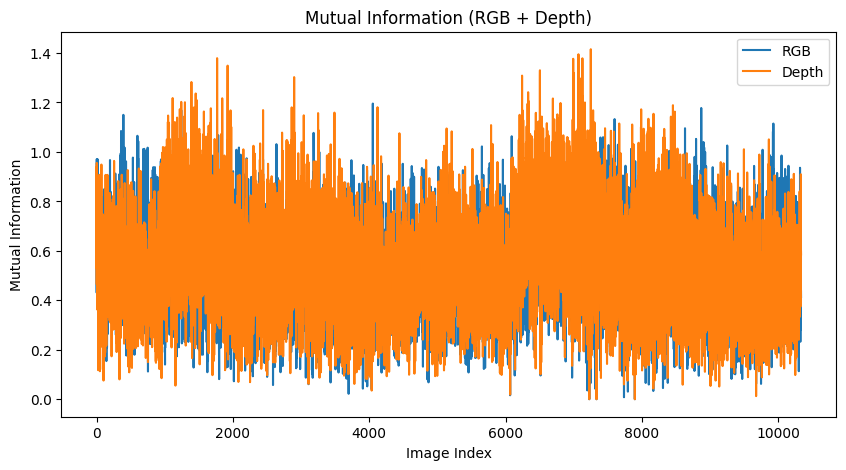

In [45]:
rgb_image_paths = rgb_image_paths
depth_image_paths = depth_image_paths

images_rgb = [np.array(Image.open(f)) for f in rgb_image_paths]
images_depth = [np.array(Image.open(f)) for f in depth_image_paths]
images_labels = [np.array(Image.open(f)) for f in label_paths]

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

mutual_information_rgb_label = [calculate_mutual_information(images_rgb[i], images_labels[i]) for i in range(len(images_rgb))]
mutual_information_depth_label = [calculate_mutual_information(images_depth[i], images_labels[i]) for i in range(len(images_depth))]

# Calculate the mutual information between RGB and depth images
plt.figure(figsize=(10, 5))
plt.plot(mutual_information_rgb_label, label="RGB")
plt.plot(mutual_information_depth_label, label="Depth")
plt.legend()
plt.title("Mutual Information (RGB + Depth)")
plt.xlabel("Image Index")
plt.ylabel("Mutual Information")
plt.show()

In [47]:
avg_mi_rgb = np.mean(mutual_information_rgb_label)
avg_mi_depth = np.mean(mutual_information_depth_label)
print("Average Mutual Information (RGB):", avg_mi_rgb)
print("Average Mutual Information (Depth):", avg_mi_depth)

Average Mutual Information (RGB): 0.5190674198216235
Average Mutual Information (Depth): 0.5513248461371251


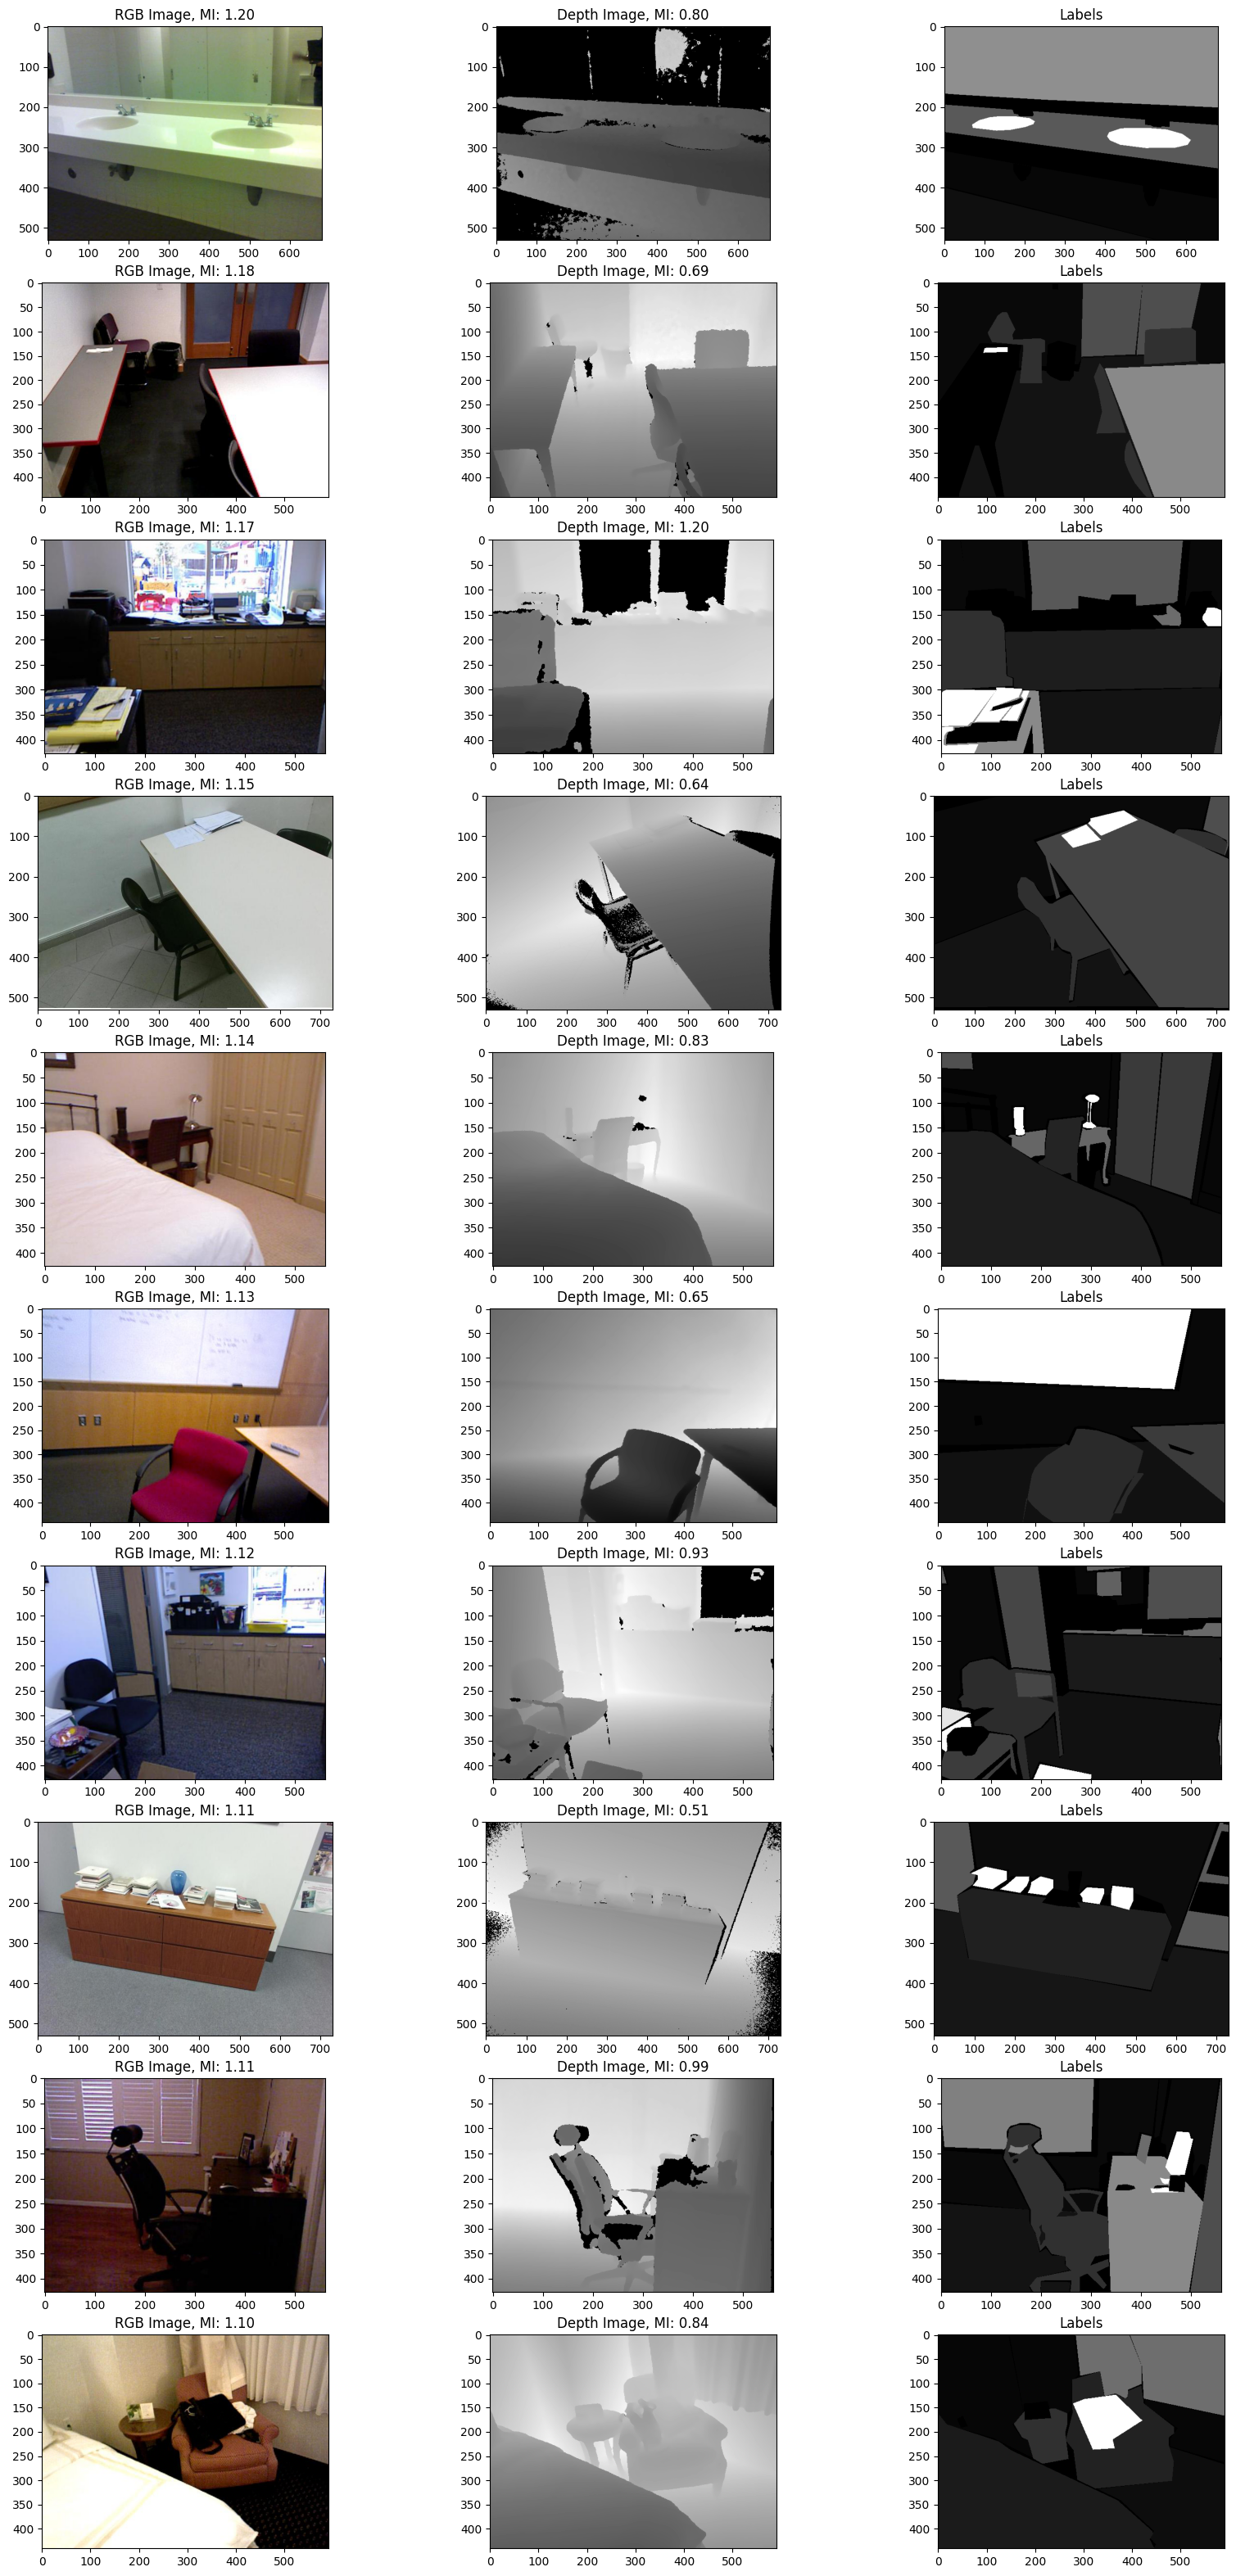

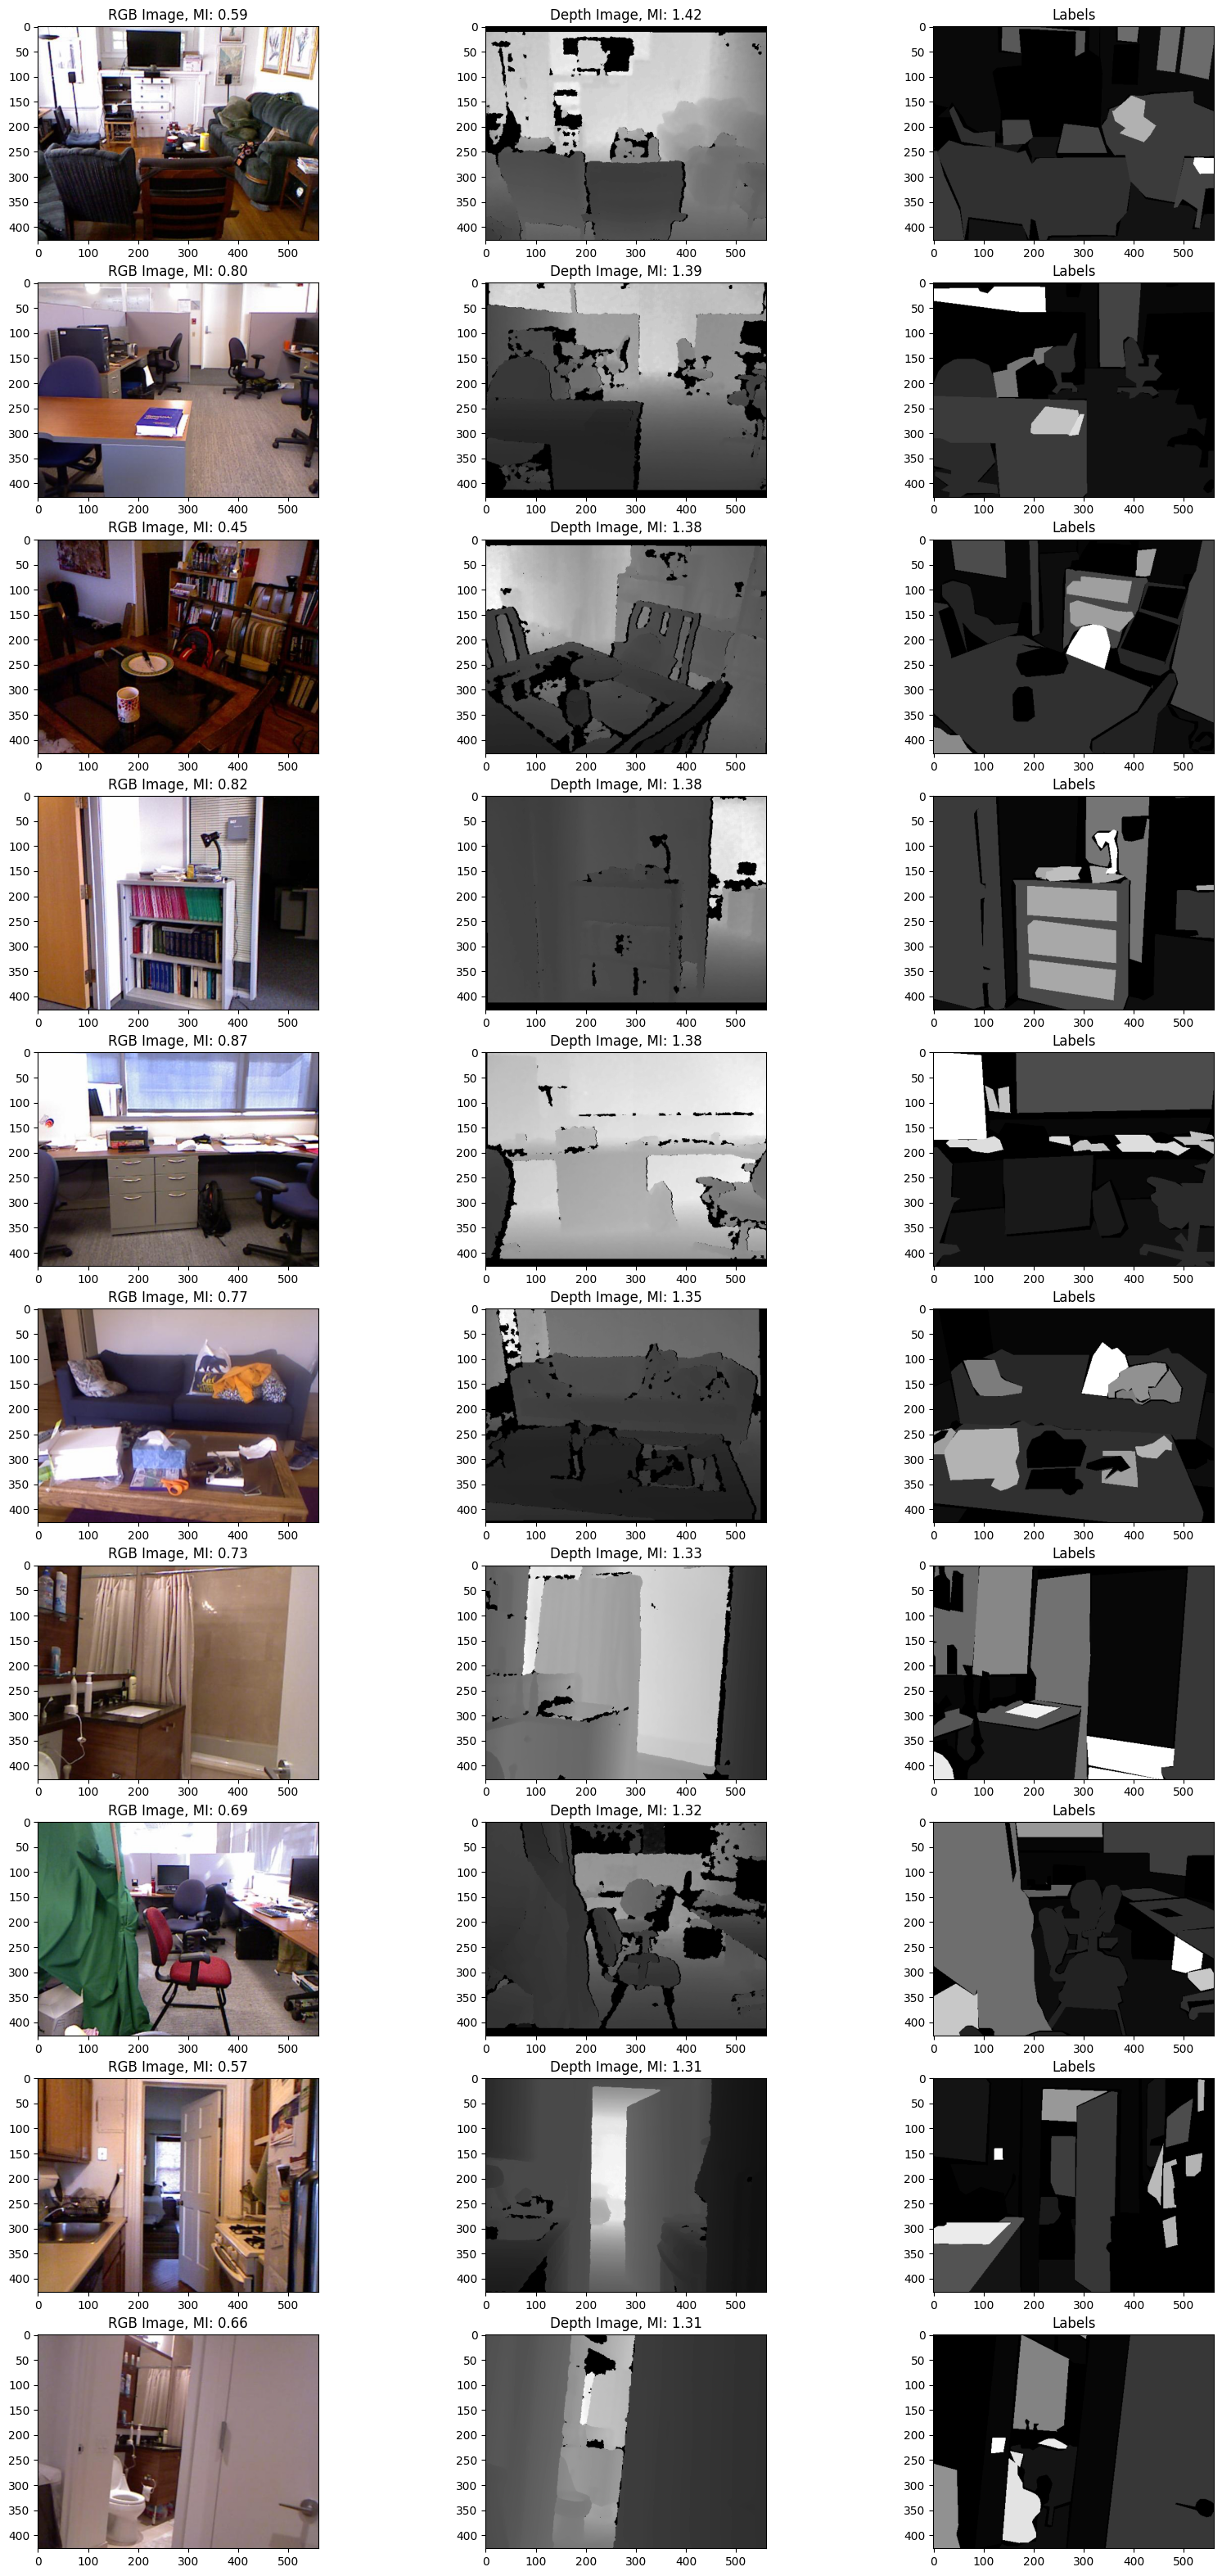

In [51]:
# Show 10 images where depth and the label have high mutual information
high_mi_depth_label = np.argsort(mutual_information_depth_label)[::-1][:10]
high_mi_rgb_label = np.argsort(mutual_information_rgb_label)[::-1][:10]

fig, ax = plt.subplots(10, 3, figsize=(20, 40))
for i in range(10):
    ax[i, 0].imshow(images_rgb[high_mi_rgb_label[i]])
    ax[i, 0].set_title("RGB Image, MI: {:.2f}".format(mutual_information_rgb_label[high_mi_rgb_label[i]]))
    ax[i, 1].imshow(images_depth[high_mi_rgb_label[i]], cmap="gray")
    ax[i, 1].set_title("Depth Image, MI: {:.2f}".format(mutual_information_depth_label[high_mi_rgb_label[i]]))
    ax[i, 2].imshow(images_labels[high_mi_rgb_label[i]], cmap="gray")
    ax[i, 2].set_title("Labels")

plt.show()

# Show 10 images where depth and the label have low mutual information
fig, ax = plt.subplots(10, 3, figsize=(20, 40))
for i in range(10):
    ax[i, 0].imshow(images_rgb[high_mi_depth_label[i]])
    ax[i, 0].set_title("RGB Image, MI: {:.2f}".format(mutual_information_rgb_label[high_mi_depth_label[i]]))
    ax[i, 1].imshow(images_depth[high_mi_depth_label[i]], cmap="gray")
    ax[i, 1].set_title("Depth Image, MI: {:.2f}".format(mutual_information_depth_label[high_mi_depth_label[i]]))
    ax[i, 2].imshow(images_labels[high_mi_depth_label[i]], cmap="gray")
    ax[i, 2].set_title("Labels")

plt.show()

In [3]:
import os
import cv2
import torch
import numpy as np

import torch.utils.data as data


class RGBXDataset2(data.Dataset):
    def __init__(self, setting, split_name, preprocess=None, file_length=None):
        super(RGBXDataset2, self).__init__()
        self._split_name = split_name
        self._rgb_path = setting['rgb_root']
        self._rgb_format = setting['rgb_format']
        self._gt_path = setting['gt_root']
        self._gt_format = setting['gt_format']
        self._transform_gt = setting['transform_gt']
        self._x_path = setting['x_root']
        self._x_format = setting['x_format']
        self._x_single_channel = setting['x_single_channel']
        self._train_source = setting['train_source']
        self._eval_source = setting['eval_source']
        self.class_names = setting['class_names']
        self._file_names = self._get_file_names(split_name)
        self._file_length = file_length
        self.preprocess = preprocess

        self.update_file_extensions()

    def __len__(self):
        if self._file_length is not None:
            return self._file_length
        return len(self._file_names)

    def __getitem__(self, index):
        if self._file_length is not None:
            item_name = self._construct_new_file_names(self._file_length)[index]
        else:
            item_name = self._file_names[index]

        item_name=item_name.split('/')[1].split('.')[0]
      
        rgb_path = os.path.join(self._rgb_path, item_name.replace('.jpg','').replace('.png','') + self._rgb_format)
        x_path = os.path.join(self._x_path, item_name.replace('.jpg','').replace('.png','')  + self._x_format)
        gt_path = os.path.join(self._gt_path, item_name.replace('.jpg','').replace('.png','')  + self._gt_format)

        gt = self._open_image(gt_path, cv2.IMREAD_UNCHANGED, dtype=np.uint8)
        rgb = self._open_image(rgb_path, cv2.IMREAD_UNCHANGED, dtype=np.int8)
        x = self._open_image(x_path, cv2.IMREAD_UNCHANGED, dtype=np.int8)

        if self.preprocess is not None:
            rgb, gt, x = self.preprocess(rgb, gt, x)

        if self._split_name == 'train':
            rgb = torch.from_numpy(np.ascontiguousarray(rgb)).float()
            gt = torch.from_numpy(np.ascontiguousarray(gt)).long()
            x = torch.from_numpy(np.ascontiguousarray(x)).float()
        else:
            rgb = torch.from_numpy(np.ascontiguousarray(rgb)).float()
            gt = torch.from_numpy(np.ascontiguousarray(gt)).long()
            x = torch.from_numpy(np.ascontiguousarray(x)).float()

        output_dict = dict(data=rgb, label=gt, modal_x=x, fn=str(item_name), n=len(self._file_names))

        return output_dict

    def _get_file_names(self, split_name):
        assert split_name in ['train', 'val']
        source = self._train_source
        if split_name == "val":
            source = self._eval_source

        file_names = []
        with open(source) as f:
            files = f.readlines()

        for item in files:
            file_name = item.strip()
            file_names.append(file_name)

        return file_names

    def _construct_new_file_names(self, length):
        assert isinstance(length, int)
        files_len = len(self._file_names)                          
        new_file_names = self._file_names * (length // files_len)   

        rand_indices = torch.randperm(files_len).tolist()
        new_indices = rand_indices[:length % files_len]

        new_file_names += [self._file_names[i] for i in new_indices]

        return new_file_names

    def get_length(self):
        return self.__len__()
    
    def update_file_extensions(self):
        rgb_file = [os.path.join(self._rgb_path, file) for file in os.listdir(self._rgb_path)][0]
        x_file = [os.path.join(self._x_path, file) for file in os.listdir(self._x_path)][0]
        gt_file = [os.path.join(self._gt_path, file) for file in os.listdir(self._gt_path)][0]

        rgb_ext = rgb_file.split('.')[-1]
        x_ext = x_file.split('.')[-1]
        gt_ext = gt_file.split('.')[-1]

        self._rgb_format = '.' + rgb_ext
        self._x_format = '.' + x_ext
        self._gt_format = '.' + gt_ext


    @staticmethod
    def _open_image(filepath, mode=cv2.IMREAD_COLOR, dtype=None):
        try:
            img = np.array(cv2.imread(filepath, mode), dtype=dtype)
        except Exception as e:
            print("Error: ", e, " filepath: ", filepath)
        return img

    @classmethod
    def get_class_colors(*args):
        def uint82bin(n, count=8):
            """returns the binary of integer n, count refers to amount of bits"""
            return ''.join([str((n >> y) & 1) for y in range(count - 1, -1, -1)])

        N = 41
        cmap = np.zeros((N, 3), dtype=np.uint8)
        for i in range(N):
            r, g, b = 0, 0, 0
            id = i
            for j in range(7):
                str_id = uint82bin(id)
                r = r ^ (np.uint8(str_id[-1]) << (7 - j))
                g = g ^ (np.uint8(str_id[-2]) << (7 - j))
                b = b ^ (np.uint8(str_id[-3]) << (7 - j))
                id = id >> 3
            cmap[i, 0] = r
            cmap[i, 1] = g
            cmap[i, 2] = b
        class_colors = cmap.tolist()
        return class_colors


In [4]:
# Utils
import sys
sys.path.append("../")

from utils.dataloader.dataloader import get_train_loader,get_val_loader
from utils.dataloader.RGBXDataset import RGBXDataset
import importlib
import torch
import matplotlib.pyplot as plt

config_path = r"..\configs\SynthDet\SynthDet_template_DFormer_Tiny.py"
config_module = importlib.import_module("configs.SUNRGBD.SUNRGBD_DFormer_Tiny")
config = config_module.config

config.dataset_path = r"..\datasets\SUNRGBD"
config.rgb_root_folder = r"..\datasets\SUNRGBD\RGB"
config.gt_root_folder = r"..\datasets\SUNRGBD\labels"
config.x_root_folder = r"..\datasets\SUNRGBD\Depth"
config.train_source = r"..\datasets\SUNRGBD\train.txt"
config.eval_source = r"..\datasets\SUNRGBD\test.txt"

train_loader, _ = get_train_loader(None, RGBXDataset2, config)
val_loader, _ = get_val_loader(None, RGBXDataset2, config, 1)

for i, batch in enumerate(train_loader):
    # imgs = minibatch['data']
    #         gts = minibatch['label']
    #         # modal_xs = minibatch['modal_x']
    imgs = batch['data']
    gts = batch['label']
    modal_xs = batch['modal_x'][0]
    # moxal_xs = (modal_xs - modal_xs.min()) / (modal_xs.max() - modal_xs.min())
    modal_xs_np = modal_xs.cpu().numpy()
    print(modal_xs_np.min(), modal_xs_np.max())
    moxal_xs = (modal_xs - modal_xs.min()) / (modal_xs.max() - modal_xs.min())
    print(moxal_xs.min(), moxal_xs.max())
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(imgs[0].permute(1, 2, 0))
    ax[1].imshow(gts[0])
    ax[2].imshow(modal_xs.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.show()

    break

In [4]:
import numpy as np
datarange = np.linspace(0.001, 5, 10)
datarange

array([1.00000000e-03, 5.56444444e-01, 1.11188889e+00, 1.66733333e+00,
       2.22277778e+00, 2.77822222e+00, 3.33366667e+00, 3.88911111e+00,
       4.44455556e+00, 5.00000000e+00])

[0]


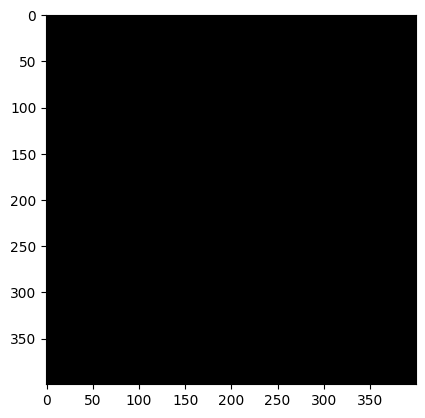

In [1]:


# C:\Users\Pasca\AppData\LocalLow\UnityTechnologies\SynthDet\solo_2p5DDepthMakesDifference\sequence.2\step0.camera.SemanticSegmentation.png
# open image
import cv2
import matplotlib.pyplot as plt
import numpy as np

image_path = r"C:\Users\Pasca\AppData\LocalLow\UnityTechnologies\SynthDet\solo_2p5DDepthMakesDifference\sequence.2\step0.camera.SemanticSegmentation.png"
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(np.unique(image))

plt.imshow(image)
plt.show()


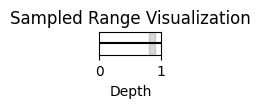

In [4]:
import matplotlib.pyplot as plt

# Define the range
depth_range = [0, 1]
sampled_range = [0.8, 0.9]

# Plotting
plt.figure(figsize=(0.8, 0.3))

# Plot the horizontal line from 0 to 1
plt.plot([depth_range[0], depth_range[1]], [0, 0], color='black')

# Shade the area representing the sampled range
plt.fill_betweenx(y=[-0.1, 0.1], x1=sampled_range[0], x2=sampled_range[1], color='gray', alpha=0.3)

# Set labels and title
plt.xlim(depth_range)
plt.ylim(-0.1, 0.1)
plt.xlabel('Depth')
plt.title('Sampled Range Visualization')

# Hide y-axis ticks and labels
plt.yticks([])

plt.show()

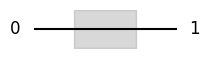

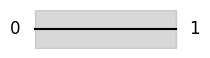

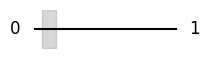

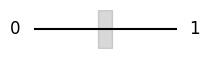

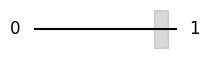

In [2]:
import matplotlib.pyplot as plt

# Define the range

sampled_ranges = [[0.28, 0.72], [0, 1], [0.05, 0.15], [0.45, 0.55], [0.85, 0.95]]
def plot_sample_range(sampled_range):
    depth_range = [0, 1]

    # Plotting
    plt.figure(figsize=(2, 0.5))

    # Plot the horizontal line from 0 to 1
    plt.plot([depth_range[0], depth_range[1]], [0, 0], color='black')

    # Shade the area representing the sampled range
    plt.fill_betweenx(y=[-0.1, 0.1], x1=sampled_range[0], x2=sampled_range[1], color='gray', alpha=0.3)

    # Set labels and title
    plt.ylim(-0.1, 0.1)

    # Hide y-axis ticks and labels
    plt.yticks([])
    plt.axis('off')

    # Add depth labels slightly outside the plot
    label_offset = 0.1
    plt.text(depth_range[0] - label_offset, 0, '0', ha='right', va='center', fontsize=12)
    plt.text(depth_range[1] + label_offset, 0, '1', ha='left', va='center', fontsize=12)

    plt.show()

for sampled_range in sampled_ranges:
    plot_sample_range(sampled_range)
